(Uncompleted) Notebook for training and testing the baseline neural network model using adjacency matrices of the AST format of the buffer overflow datapoints. In order for the matrices to be fed into the neural network, they must all be of the same dimensions. We are currently working on padding all of the matrices to have the same size namely, 44401 x 44401. We are currently unsucessful as the kernel keeps dying.

# Colab Setup

In [1]:
!mkdir -p /project/data && cd /project/data && wget -O adj.pickle https://github.com/dj311/uob-summer-project/raw/master/data/adj.pickle
!mkdir -p /project/data && cd /project/data && wget -O buffer_overflow_data.csv.gz https://github.com/dj311/uob-summer-project/raw/master/data/buffer_overflow_data.csv.gz
!mkdir -p /project/code
%cd /project/code

--2019-07-24 10:43:34--  https://github.com/dj311/uob-summer-project/raw/master/data/adj.pickle
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/dj311/uob-summer-project/master/data/adj.pickle [following]
--2019-07-24 10:43:34--  https://media.githubusercontent.com/media/dj311/uob-summer-project/master/data/adj.pickle
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1320521199 (1.2G) [application/octet-stream]
Saving to: ‘adj.pickle’

adj.pickle          100%[===================>]   1.23G   198MB/s    in 6.3s    

2019-07-24 10:43:54 (201 MB/s) - ‘adj.pickle’ saved [1320521199/132052119

# Import & Preprocess Dataset

First we import the data from the [previous notebook](./adjacency_matrix.ipynb).


In [1]:
import tensorflow
import keras
import sklearn
import numpy as np
np.random.seed(1248)
import pickle
from scipy.sparse import csr_matrix, hstack, vstack
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
import tensorflow
import keras
import numpy as np
import pickle
from scipy.sparse import csr_matrix

In [3]:
import pandas as pd

In [4]:
data = pd.read_csv('../data/buffer_overflow_data.csv.gz')

In [5]:
labels = data.copy()
del labels['Unnamed: 0']
del labels['Unnamed: 0.1']
del labels['filename']
del labels['code']
del labels['flaw']
del labels['flaw_loc']
labels = labels.drop_duplicates().sort_values('testcase_ID').reset_index(drop=True)

In [6]:
with open("../data/adj.pickle",'rb') as f:
    adj = pickle.load(f)

In [7]:
adj = adj.rename(columns={0: 'testcase_ID', 1: 'matrix'})

In [8]:
adj_df = pd.merge(labels, adj, on='testcase_ID')

In [9]:
adj_df = adj_df[['testcase_ID', 'matrix', 'bug']]

Next, find out the maximum size of an adjacency matrix, then convert all matrices to have the same dimension.

In [10]:
adj_df['matrix_size'] = adj_df.matrix.apply(lambda x: x.shape[0])

In [11]:
adj_df['matrix_size'].describe()

count    21502.000000
mean      2186.138778
std       7239.752920
min          4.000000
25%        349.000000
50%        396.000000
75%        614.000000
max      44401.000000
Name: matrix_size, dtype: float64

So we know that 75% of the dataset has a matrix size <= 614, which is approximately 18000 datapoints. Picking the full dataset would require matrices of dimension 44401x44401 which require 15 gb of memory each. This is isn't feasible, however picking matrices of size 614x614 or less gives a per matrix size of 3.38mb - far more manageable!

In [12]:
matrix_size = 614
adj_df = adj_df[adj_df['matrix_size'] <= matrix_size]
len(adj_df)

16128

In [13]:
adj_df['matrix'].values[0]

<395x395 sparse matrix of type '<class 'numpy.int64'>'
	with 788 stored elements in Compressed Sparse Row format>

In [0]:
def matrix_size_corrector(matrix, size):
    '''Pads matrix with zeros to the desired size'''
    
    rows, columns = matrix.shape[0], matrix.shape[1]
    
    row_corrector = csr_matrix((size-rows, rows))
    col_corrector = csr_matrix((size, size-columns))

    matrix = vstack([matrix, row_corrector])
    matrix = hstack([matrix, col_corrector])

    matrix = matrix.astype(np.int)
    
    return matrix 

In [0]:
adj_df['matrix'] = adj_df['matrix'].apply(lambda m: matrix_size_corrector(m, matrix_size))

Now we have a dataframe for each testcase with a sparse representation of its AST in the matrix column, each normalised to matrix_size x matrix_size in size.

Now, to input this into our model, we create three numpy arrays, linked by their index:
  1. `testcase_ids` gives the testcase ID of each row
  2. `adjacency_matrices` is an array of 2D adjacency matrices
  3. `labels` tells us whether each row contains a bug or not
  
  



In [0]:
testcase_ids = adj_df['testcase_ID'].values
adjacency_matrices = adj_df['matrix'].values
labels = adj_df['bug'].values

Storing all of these matrices in a dense representation at once might cause memory issues. To avoid this, we write a class which generates dense matrices for each of the training batches. 

We also perform the element wrapping as part of this process (since we can't perform it on the sparse arrays, I think).

In [0]:
class SparseToDenseGenerator(keras.utils.Sequence):

    def __init__(self, sparse_matrices, labels, batch_size):
        self.sparse_matrices = sparse_matrices
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.sparse_matrices) / float(self.batch_size)))

    def __getitem__(self, batch_num):
        start_index = batch_num * self.batch_size
        end_index = (batch_num + 1) * self.batch_size
        
        batch_sparse = self.sparse_matrices[start_index:end_index]
        batch_labels = self.labels[start_index:end_index]
        
        batch_dense = np.array([sparse_matrix.todense() for sparse_matrix in batch_sparse])
        
        # TODO: move this somewhere better
        # Conv2D requires an extra dimension for "channels", so we need to convert our data from
        # the shape (batch_size, matrix_rows, matrix_columns)
        # to (batch_size, matrix_rows, matrix_columns, 1)
        batch_dense = np.reshape(batch_dense, batch_dense.shape + (1, ))

        return batch_dense, np.array(batch_labels)

Finally, we generate the train and test splits:

In [0]:
x_train, x_test, y_train, y_test = train_test_split(adjacency_matrices, labels, test_size=0.2)

# Model

In [16]:
import matplotlib.pyplot as plt

In [17]:
adjacency_matrices[0].toarray()

NameError: name 'adjacency_matrices' is not defined

In [18]:
import random

In [70]:
testcase = set(adj_df['testcase_ID'])

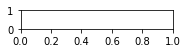

In [73]:
plt.subplot(10, 2, 1)

In [76]:
list(range(1,20,2))

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19]

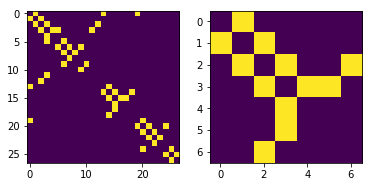

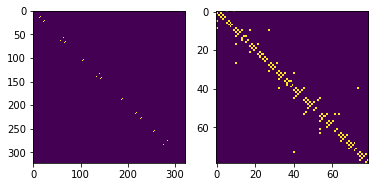

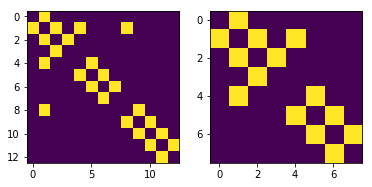

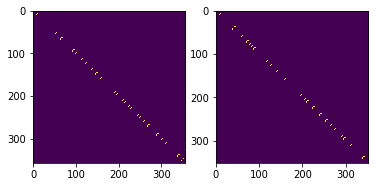

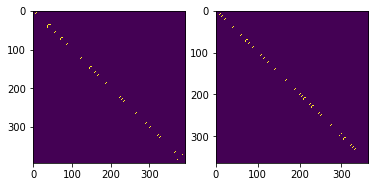

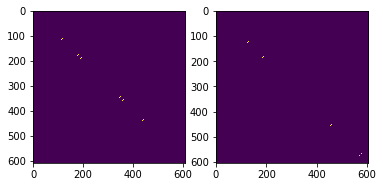

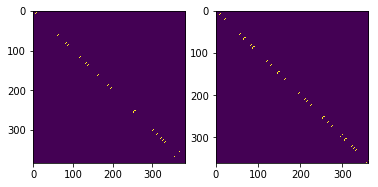

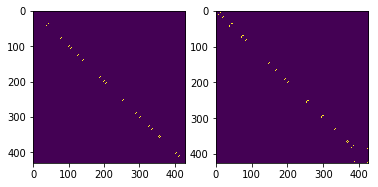

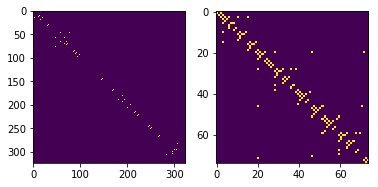

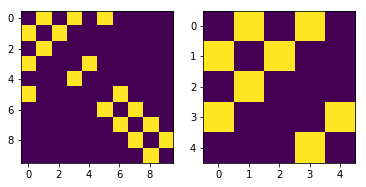

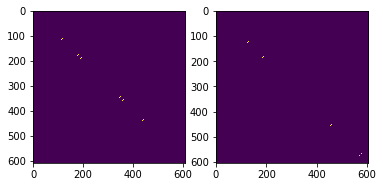

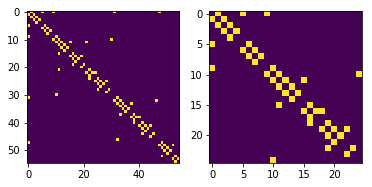

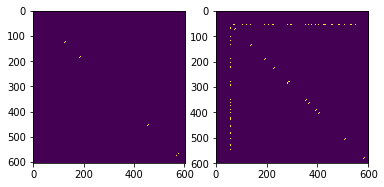

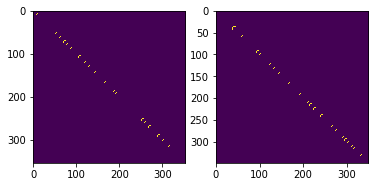

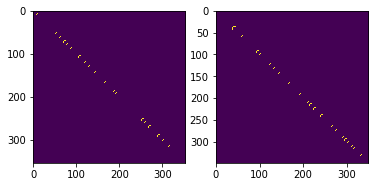

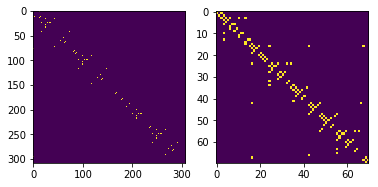

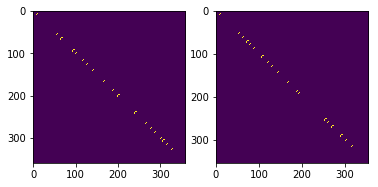

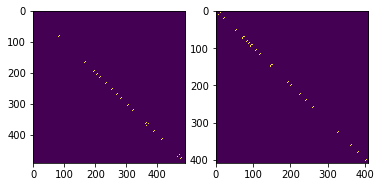

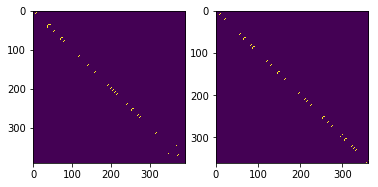

In [87]:
for j in range(1,20):
    i = random.sample(testcase,1)[0]
    # if i is negative then get the positive num
    if i < 0:
        i = -i
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(adj_df.loc[adj_df['testcase_ID'] == i].iloc[0].matrix.toarray())
    plt.subplot(1, 2, 2)
    plt.imshow(adj_df.loc[adj_df['testcase_ID'] == -i].iloc[0].matrix.toarray())
    plt.savefig('../images/%s.png'%(j))

In [85]:
adj_df['matrix'].values[0]

<395x395 sparse matrix of type '<class 'numpy.int64'>'
	with 788 stored elements in Compressed Sparse Row format>

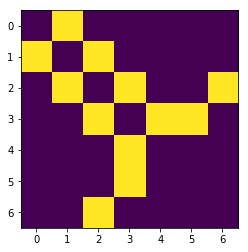

In [69]:
plt.imshow(adj_df['matrix'].values[random.randrange(10000)].toarray())

In [38]:
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv1D, MaxPooling1D, Conv2D, GlobalMaxPooling2D
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop, Adadelta, Adam

In [0]:
batch_size = 64
epochs=2
num_samples = len(labels)

datapoint_shape = (matrix_size, matrix_size, )
batch_shape = (batch_size, ) + datapoint_shape

steps_per_epoch = int(np.ceil(num_samples/batch_size))

In [0]:
import tensorflow as tf
run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

In [30]:
datapoint_shape

(614, 614)

In [0]:
import numpy as np
np.random.seed(1337)  # for reproducibility
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

In [0]:
nb_filters = 100
pool_size = 3
input_shape = datapoint_shape

In [33]:
b_model = Sequential()

b_model.add(Convolution2D(nb_filters, (100, 100),
                        padding='same',
                        input_shape=(matrix_size, matrix_size, 1))) # 卷积层1
b_model.add(Activation('sigmoid')) #激活层
b_model.add(Convolution2D(nb_filters, (10, 10))) #卷积层2
b_model.add(Activation('sigmoid')) #激活层
b_model.add(MaxPooling2D(pool_size=pool_size)) #池化层
b_model.add(Dropout(0.25)) #神经元随机失活
b_model.add(Convolution2D(nb_filters, (10, 10))) #卷积层2
b_model.add(Activation('sigmoid')) #激活层
b_model.add(MaxPooling2D(pool_size=pool_size)) #池化层
b_model.add(Dropout(0.25)) #神经元随机失活

b_model.add(Convolution2D(nb_filters, (10, 10))) #卷积层2
b_model.add(Activation('sigmoid')) #激活层
b_model.add(MaxPooling2D(pool_size=pool_size)) #池化层
b_model.add(Dropout(0.25)) #神经元随机失活

#model.add(Flatten()) #拉成一维数据
b_model.add(Dense(128)) #全连接层1
b_model.add(Activation('sigmoid')) #激活层
b_model.add(Dropout(0.5)) #随机失活

# model.add(Flatten()) #拉成一维数据
# model.add(Activation('sigmoid')) #激活层
# model.add(Dropout(0.5)) #随机失活

b_model.add(Dense(1)) #全连接层2
b_model.add(Activation('sigmoid')) #Softmax评分


b_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

b_model.summary()

W0724 10:45:09.237867 140159329916800 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0724 10:45:09.297237 140159329916800 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0724 10:45:09.305321 140159329916800 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0724 10:45:09.357675 140159329916800 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0724 10:45:09.361230 140159329916800 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 614, 614, 100)     1000100   
_________________________________________________________________
activation_1 (Activation)    (None, 614, 614, 100)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 605, 605, 100)     1000100   
_________________________________________________________________
activation_2 (Activation)    (None, 605, 605, 100)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 201, 201, 100)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 201, 201, 100)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 192, 192, 100)     1000100   
__________

In [34]:
model = Sequential()

model.add(Conv2D(
    data_format='channels_last',
    input_shape=(matrix_size, matrix_size, 1),
    filters=1,
    kernel_size=2,
    activation = 'sigmoid'
))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))
model.add(GlobalMaxPooling2D())

#model.add(Flatten())

model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'], options = run_opts)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 613, 613, 1)       5         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 613, 613, 1)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 613, 613, 1)       0         
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 1)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


In [0]:
training_batch_generator = SparseToDenseGenerator(x_train, y_train, batch_size)

model.fit_generator(
    generator=training_batch_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    verbose=2,
)

Epoch 1/2


# Evaluation

In [0]:
import pickle

In [0]:

with open('../data/adjacency-matrix-model-binary','wb') as f:
    pickle.dump(model,f)

In [0]:
model.evaluate(x_test,y_test)

10751/10751 [==============================] - 1s 61us/step


[0.20033853630328355, 0.9128453166371068]

In [0]:
import seaborn as sns
from sklearn import metrics
import matplotlib

In [0]:
y_predict= model.predict(x_test)

In [0]:
import numpy as np

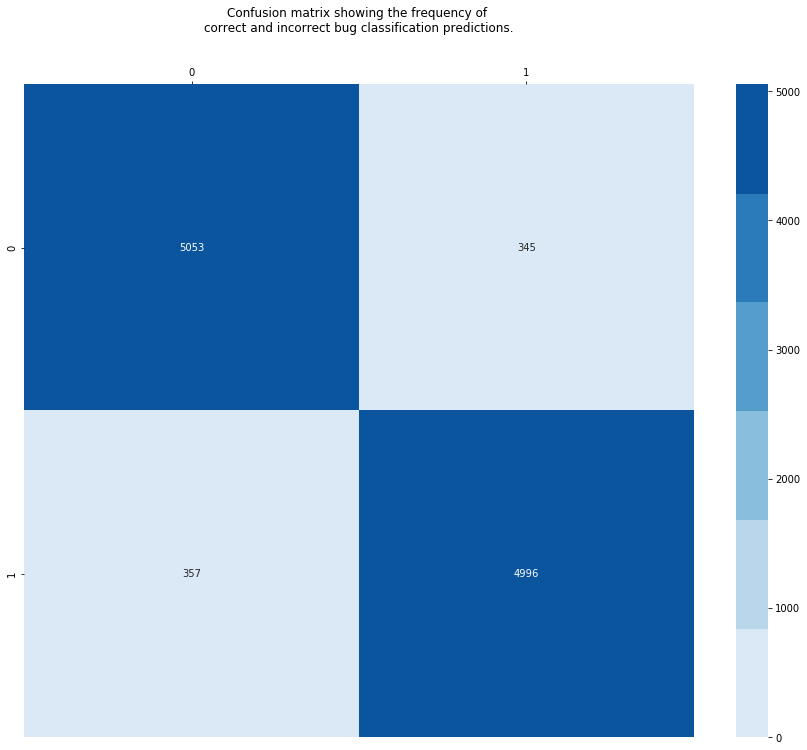

In [0]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test, np.rint(y_predict)), 
    
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(15, 12)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [0]:
confusion_matrices = metrics.multilabel_confusion_matrix(
    (y_test+0).values,
    np.rint(y_predict)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


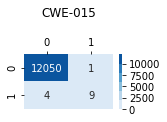

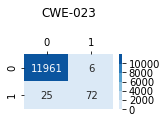

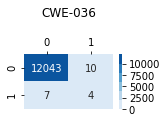

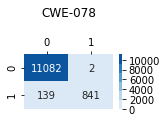

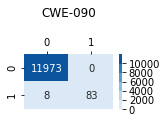

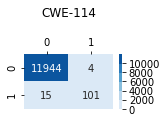

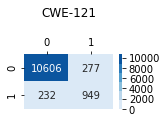

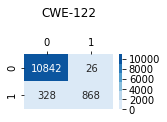

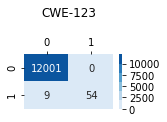

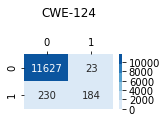

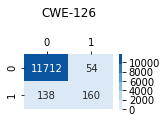

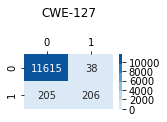

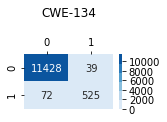

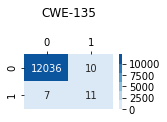

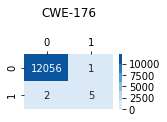

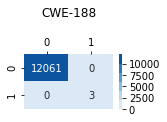

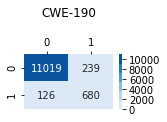

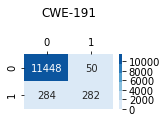

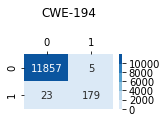

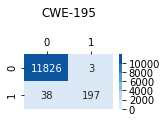

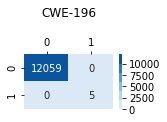

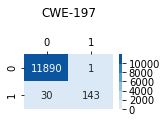

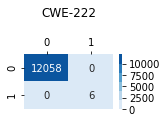

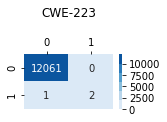

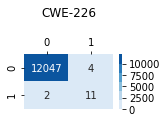

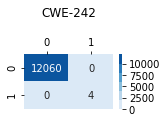

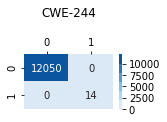

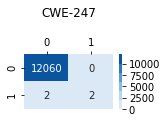

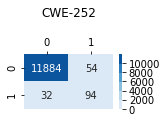

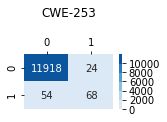

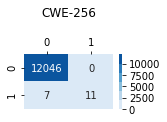

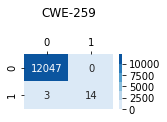

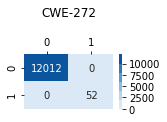

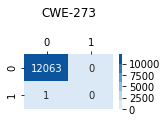

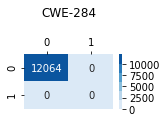

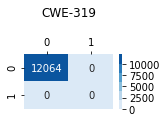

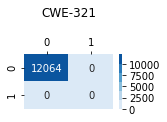

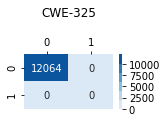

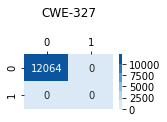

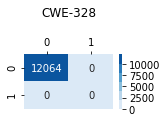

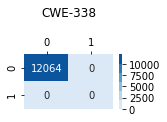

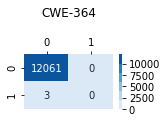

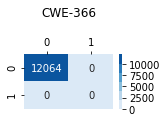

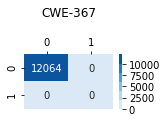

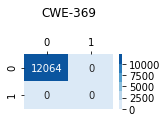

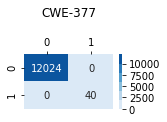

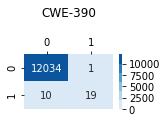

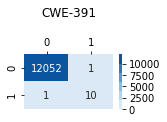

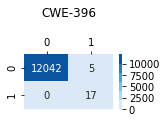

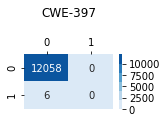

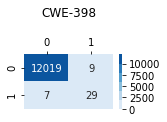

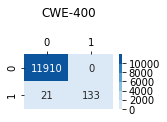

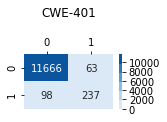

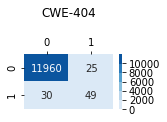

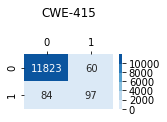

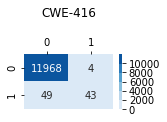

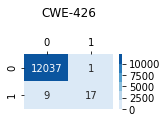

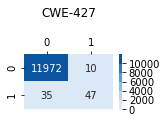

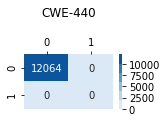

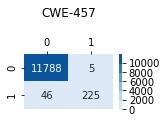

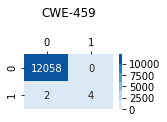

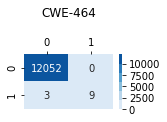

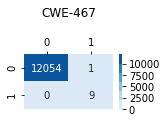

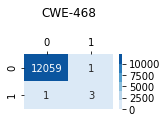

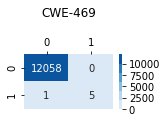

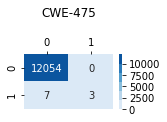

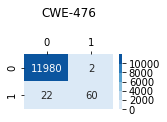

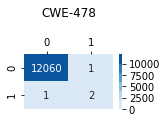

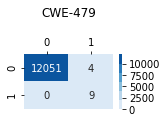

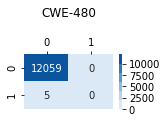

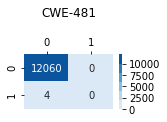

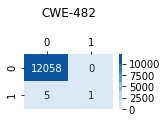

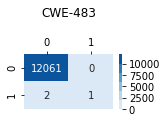

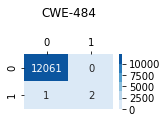

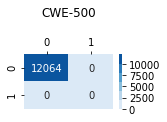

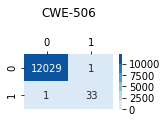

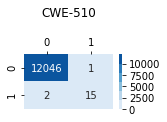

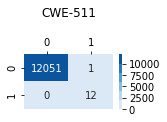

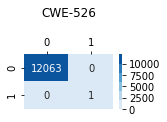

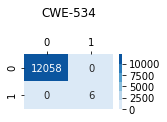

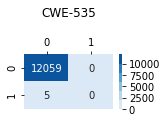

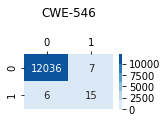

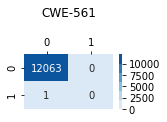

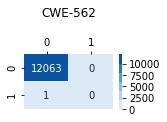

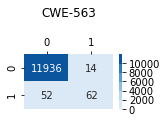

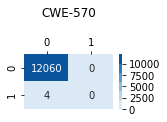

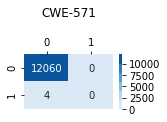

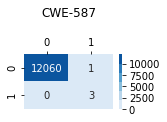

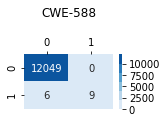

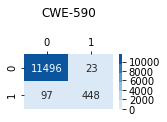

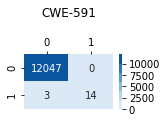

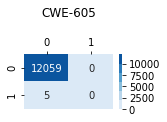

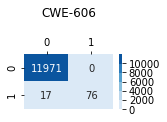

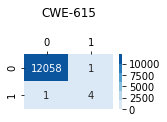

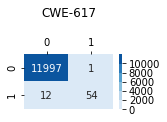

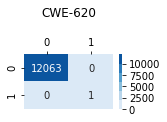

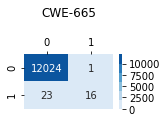

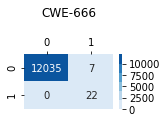

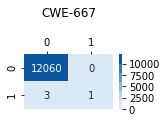

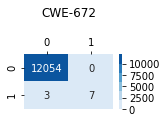

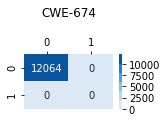

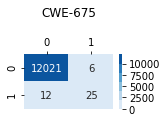

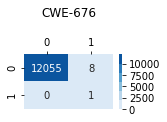

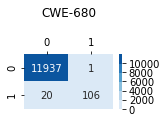

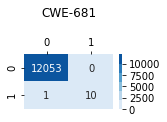

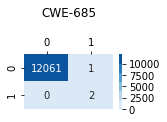

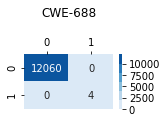

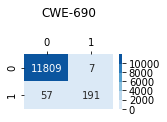

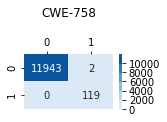

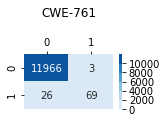

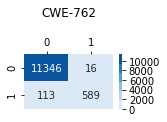

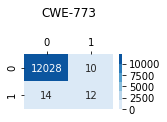

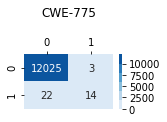

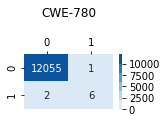

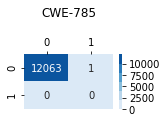

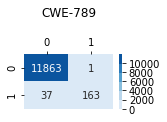

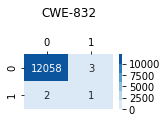

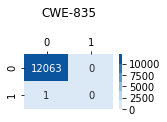

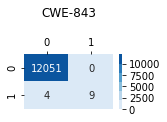

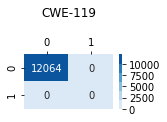

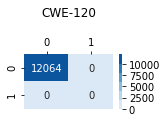

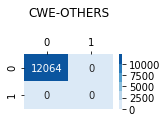

In [0]:
for label, confusion_matrix in zip(y_test.columns, confusion_matrices):

    confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
    confusion_figure.set_size_inches(2, 1)
    confusion_axes.set_title(
        label + 
        '\n'  # hack to avoid overlap with x-axis labels below
    )
    confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
    _ = sns.heatmap(
        confusion_matrix,
        annot=True,
        fmt="d",
        cmap=sns.color_palette("Blues"),
        vmin=0,
        ax=confusion_axes,
    )

In [0]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve((y_test.values+0).argmax(axis=1)-5, y_predict.argmax(axis=1)-5)

ValueError: multiclass format is not supported

In [0]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt
auc_keras = auc(fpr_keras, tpr_keras)

NameError: name 'fpr_keras' is not defined

In [0]:
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [0]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix((y_test.values+0).argmax(axis=1), y_predict.argmax(axis=1)), 
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(10, 8)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [0]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [0]:
rf.score(x_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.4053359315636961

In [0]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf1 = RandomForestRegressor(n_estimators = 100, random_state = 42)
# Train the model on training data
rf1.fit(x_train, y_train)

In [0]:
rf1.score(x_test, y_test)

In [0]:
from pyspark import SparkContext
import os 

# this should be JAVA_HOME path
os.environ['JAVA_HOME']="/Library/Java/JavaVirtualMachines/jdk1.8.0_202.jdk/Contents/Home/"

os.environ['PYSPARK_SUBMIT_ARGS'] = "--master local[2] pyspark-shell"

sc = SparkContext.getOrCreate()

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("test").getOrCreate()

In [0]:
xtemp = x_test.values.tolist()

In [0]:
temp = pd.DataFrame()

In [0]:
df = spark.createDataFrame()

TypeError: createDataFrame() missing 1 required positional argument: 'data'

In [0]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'result', labelCol = 'categorylabel')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('label', 'prediction', 'probability').show(10)

AttributeError: Cannot load _jvm from SparkContext. Is SparkContext initialized?

In [0]:
from pyspark.ml.classification import LogisticRegression
train, test = indexed.randomSplit([0.8, 0.2], seed = 7*4*25)
